This notebook contains BDT variables' distribution for signals of representative parameter points.</br>
In the last part, signal's fractions with different dphi cut was plotted.

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor
import uproot

import numpy as np
import matplotlib.pyplot as plt
from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged
from FireHydrant.Tools.metfilter import MetFilters

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json

dataset4mu_ = json.load(open('../Samples/signal_4mu.json'))
dataset2mu2e_ = json.load(open('../Samples/signal_2mu2e.json'))

In [3]:
dataset={
    '4mu/mXX-100_mA-5': dict(files=dataset4mu_['mXX-100_mA-5'], treename='ffNtuplizer/ffNtuple'),
    '4mu/mXX-1000_mA-0p25': dict(files=dataset4mu_['mXX-1000_mA-0p25'], treename='ffNtuplizer/ffNtuple'),
    '2mu2e/mXX-100_mA-5': dict(files=dataset2mu2e_['mXX-100_mA-5'], treename='ffNtuplizer/ffNtuple'),
    '2mu2e/mXX-1000_mA-0p25': dict(files=dataset2mu2e_['mXX-1000_mA-0p25'], treename='ffNtuplizer/ffNtuple'),
}

## Variables as input for BDT
- leptonJet pT, eta
- neutral energy fraction
- maxd0, mind0
- tkiso, pfiso
- spreadpt, spreaddr
- lambda, epsilon
- ecf 1,2,3

and
- BDT score

In [4]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Representative datasets')
        pt0_axis      = hist.Bin("pt", "pT [GeV]", 50, 0, 200) # small range
        pt1_axis      = hist.Bin("pt", "pT [GeV]", 50, 0, 750) # large range
        mass_axis     = hist.Bin("mass", "mass [GeV]", 50, 0, 25)
        
        eta_axis      = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        nef_axis      = hist.Bin("nef", "neutral energy fraction", 50, 0, 1)
        maxd0_axis    = hist.Bin("maxd0", 'track max |d0|', 50, 0, 0.5)
        mind0_axis    = hist.Bin("mind0", 'track min |d0|', 50, 0, 0.5)
        tkiso_axis    = hist.Bin('tkiso', 'track isolation', 50, 0, 1)
        pfiso_axis    = hist.Bin("pfiso", "PFCands isolation", 50, 0, 1)
        spreadpt_axis = hist.Bin("spreadpt", "spreadpt", 50, 0, 1)
        spreaddr_axis = hist.Bin("spreaddr", "spreaddr", 50, 0, 0.1)
        lambda_axis   = hist.Bin('lamb', 'jet sub - lambda', 50, -8, 0)
        epsilon_axis  = hist.Bin('epsi', 'jet sub - epsilon', 50, 0, 0.25)
        ecfe1_axis    = hist.Bin('ecfe1', 'energy correlation function - e1', 50, 0, 200)
        ecfe2_axis    = hist.Bin('ecfe2', 'energy correlation function - e2', 50, 0, 500)
        ecfe3_axis    = hist.Bin('ecfe3', 'energy correlation function - e3', 50, 0, 300)
        mva_axis      = hist.Bin('mva', 'BDT value', 50, -10, 10)
        
        self._accumulator = processor.dict_accumulator({
            'pt0': hist.Hist("norm. counts/4GeV", dataset_axis, pt0_axis),
            'pt1': hist.Hist("norm. counts/15GeV", dataset_axis, pt1_axis),
            'mass': hist.Hist("norm. counts/0.5GeV", dataset_axis, mass_axis),
            
            "eta": hist.Hist("norm. counts/0.096", dataset_axis, eta_axis),
            "nef": hist.Hist("norm. counts/0.02", dataset_axis, nef_axis),
            "maxd0": hist.Hist("norm. counts/0.01cm", dataset_axis, maxd0_axis),
            "mind0": hist.Hist("norm. counts/0.01cm", dataset_axis, mind0_axis),
            "tkiso": hist.Hist("norm. counts/0.02", dataset_axis, tkiso_axis),
            "pfiso": hist.Hist("norm. counts/0.02", dataset_axis, pfiso_axis),
            "spreadpt": hist.Hist("norm. counts/0.02", dataset_axis, spreadpt_axis),
            "spreaddr": hist.Hist("norm. counts/0.002", dataset_axis, spreaddr_axis),
            "lamb": hist.Hist("norm. counts/0.16", dataset_axis, lambda_axis),
            "epsi": hist.Hist("norm. counts/0.005", dataset_axis, epsilon_axis),
            "ecfe1": hist.Hist("norm. counts/4", dataset_axis, ecfe1_axis),
            "ecfe2": hist.Hist("norm. counts/10", dataset_axis, ecfe2_axis),
            "ecfe3": hist.Hist("norm. counts/6", dataset_axis, ecfe3_axis),
            "mva": hist.Hist("norm. counts/0.4", dataset_axis, mva_axis),
        })

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        maxd0_ = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0).max()
        mind0_ = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0).min()
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            nef=(df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT'],
            maxd0=maxd0_.content,
            mind0=mind0_.content,
            tkiso=df['pfjet_tkIsolation05'],
            pfiso=df['pfjet_pfIsolation05'],
            spreadpt=df['pfjet_ptDistribution'],
            spreaddr=df['pfjet_dRSpread'],
            lamb=df['pfjet_subjet_lambda'],
            epsi=df['pfjet_subjet_epsilon'],
            ecf1=df['pfjet_subjet_ecf1'],
            ecf2=df['pfjet_subjet_ecf2'],
            ecf3=df['pfjet_subjet_ecf3'],
            mva=df['pfjet_mva'],
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid']
        )
        darkphotons = genparticles[genparticles.pid==32]
        
        matchmask = leptonjets.match(darkphotons, deltaRCut=0.3)
        metfiltermask = np.logical_or.reduce([df[mf] for mf in MetFilters])
        
        leptonjets_ = leptonjets[matchmask][metfiltermask]
        
        output['pt0']     .fill(dataset=dataset, pt=leptonjets_.pt.flatten())
        output['pt1']     .fill(dataset=dataset, pt=leptonjets_.pt.flatten())
        output['mass']    .fill(dataset=dataset, mass=leptonjets_.mass.flatten())
        output['eta']     .fill(dataset=dataset, eta=leptonjets_.eta.flatten())
        output['nef']     .fill(dataset=dataset, nef=leptonjets_.nef.flatten())
        output['maxd0']   .fill(dataset=dataset, maxd0=leptonjets_.maxd0.flatten())
        output['mind0']   .fill(dataset=dataset, mind0=leptonjets_.mind0.flatten())
        output['tkiso']   .fill(dataset=dataset, tkiso=leptonjets_.tkiso.flatten())
        output['pfiso']   .fill(dataset=dataset, pfiso=leptonjets_.pfiso.flatten())
        output['spreadpt'].fill(dataset=dataset, spreadpt=leptonjets_.spreadpt.flatten())
        output['spreaddr'].fill(dataset=dataset, spreaddr=leptonjets_.spreaddr.flatten())
        output['lamb']    .fill(dataset=dataset, lamb=leptonjets_.lamb.flatten())
        output['epsi']    .fill(dataset=dataset, epsi=leptonjets_.epsi.flatten())
        output['ecfe1']   .fill(dataset=dataset, ecfe1=leptonjets_.ecf1.flatten())
        output['ecfe2']   .fill(dataset=dataset, ecfe2=leptonjets_.ecf2.flatten())
        output['ecfe3']   .fill(dataset=dataset, ecfe3=leptonjets_.ecf3.flatten())
        output['mva']     .fill(dataset=dataset, mva=leptonjets_.mva.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [5]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing:   0%|          | 0/20 [00:00<?, ?items/s]/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/

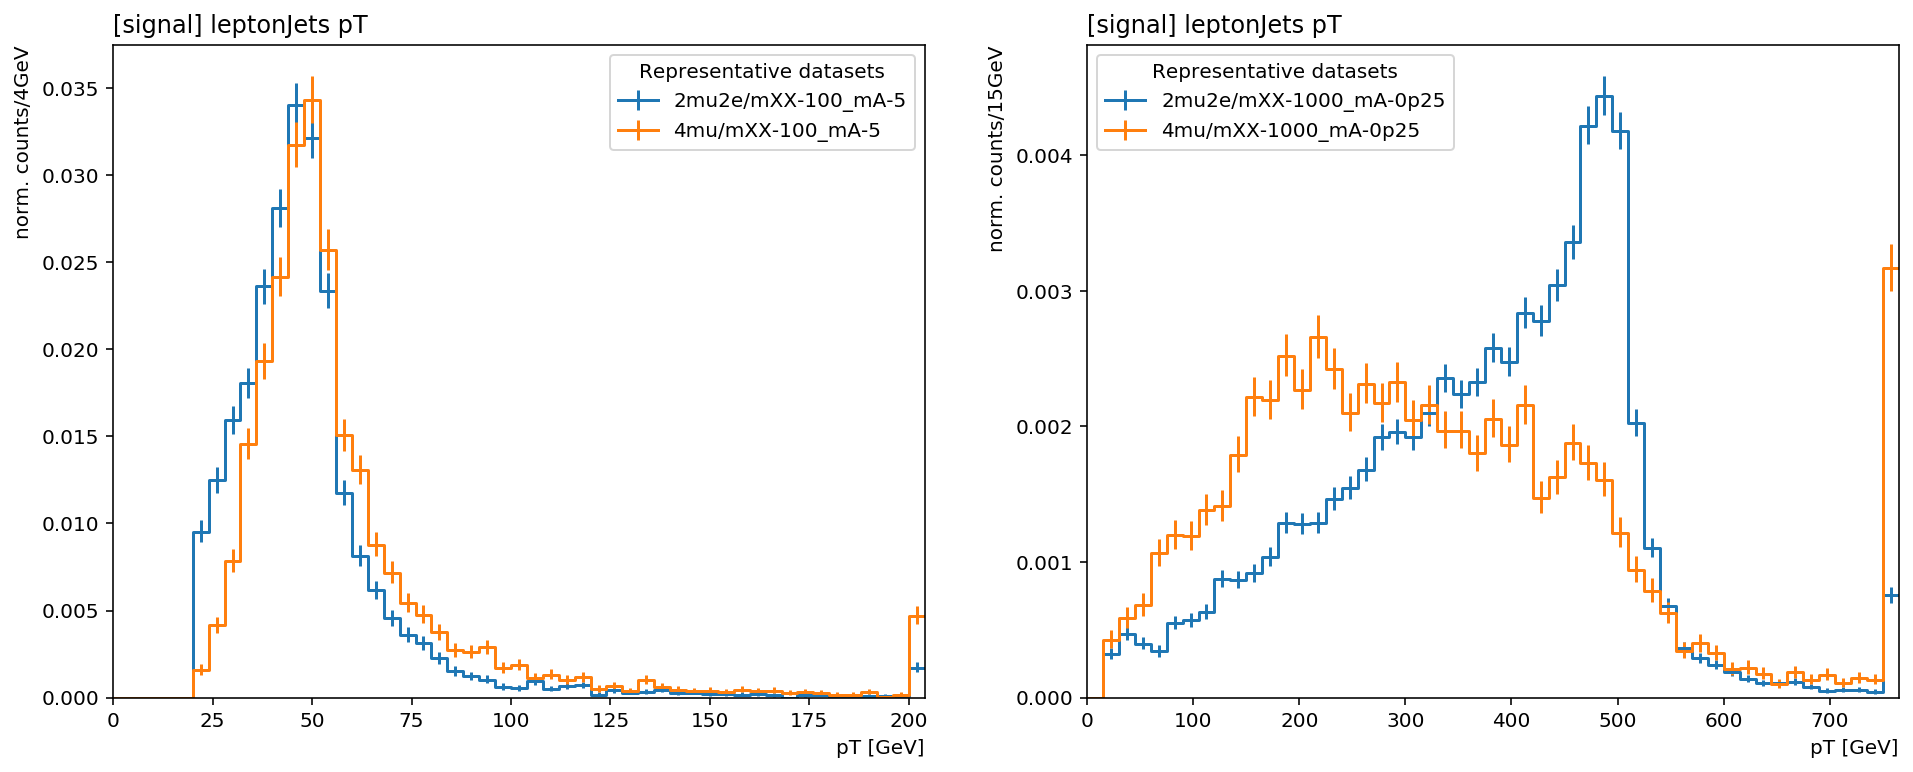

In [6]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig,ax,_ = hist.plot1d(output['pt0']['*/mXX-100_mA-5'], overlay='dataset', ax=axes[0], density=True, overflow='over')
fig,ax,_ = hist.plot1d(output['pt1']['*/mXX-1000_mA-0p25'], overlay='dataset', ax=axes[1], density=True, overflow='over')


for ax in axes:
#     ax.set_yscale('log')
    ax.set_title('[signal] leptonJets pT', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

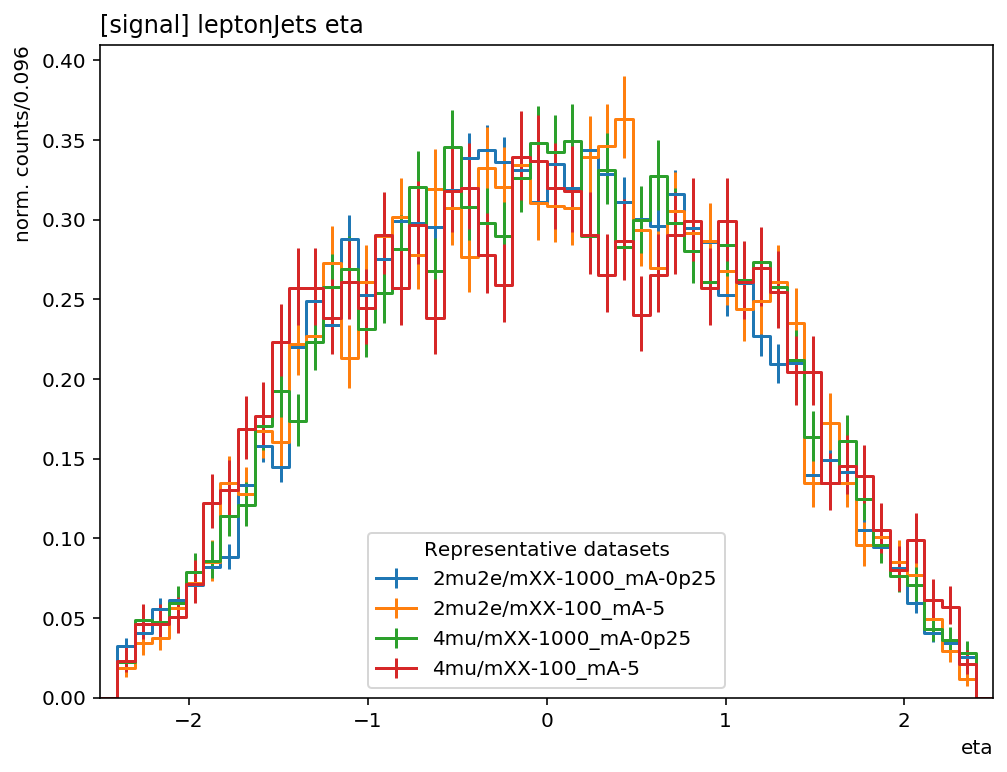

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['eta'], overlay='dataset', ax=ax, density=True, overflow='all')

# ax.set_yscale('log')
ax.set_title('[signal] leptonJets eta', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

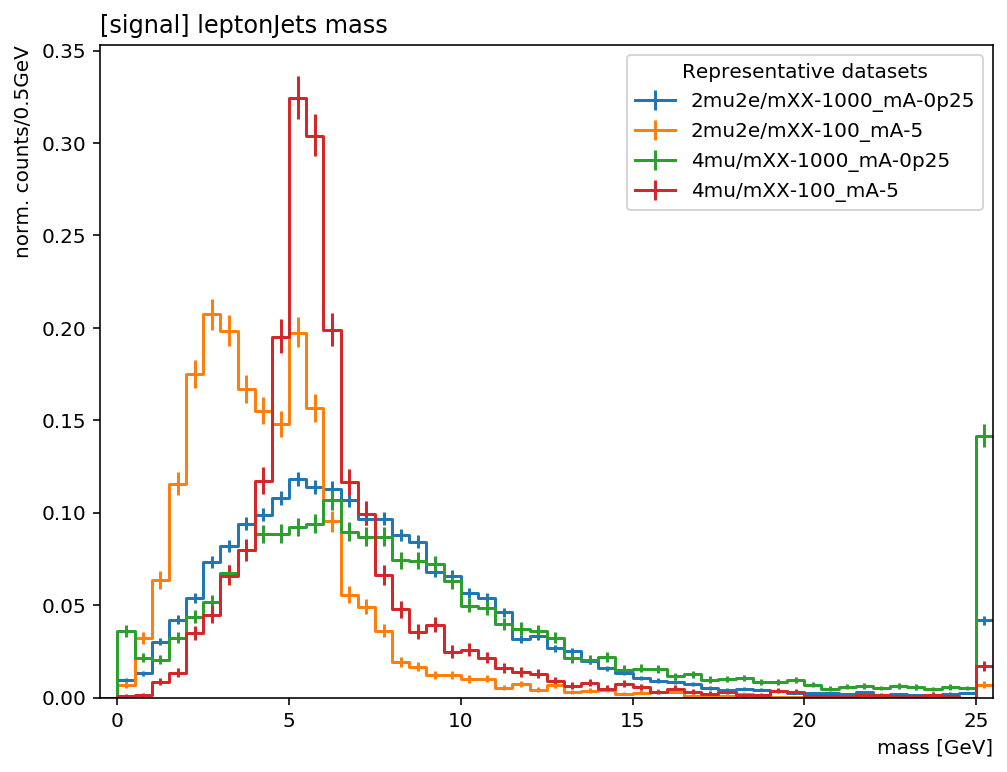

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['mass'], overlay='dataset', ax=ax, density=True, overflow='all')

# ax.set_yscale('log')
ax.set_title('[signal] leptonJets mass', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

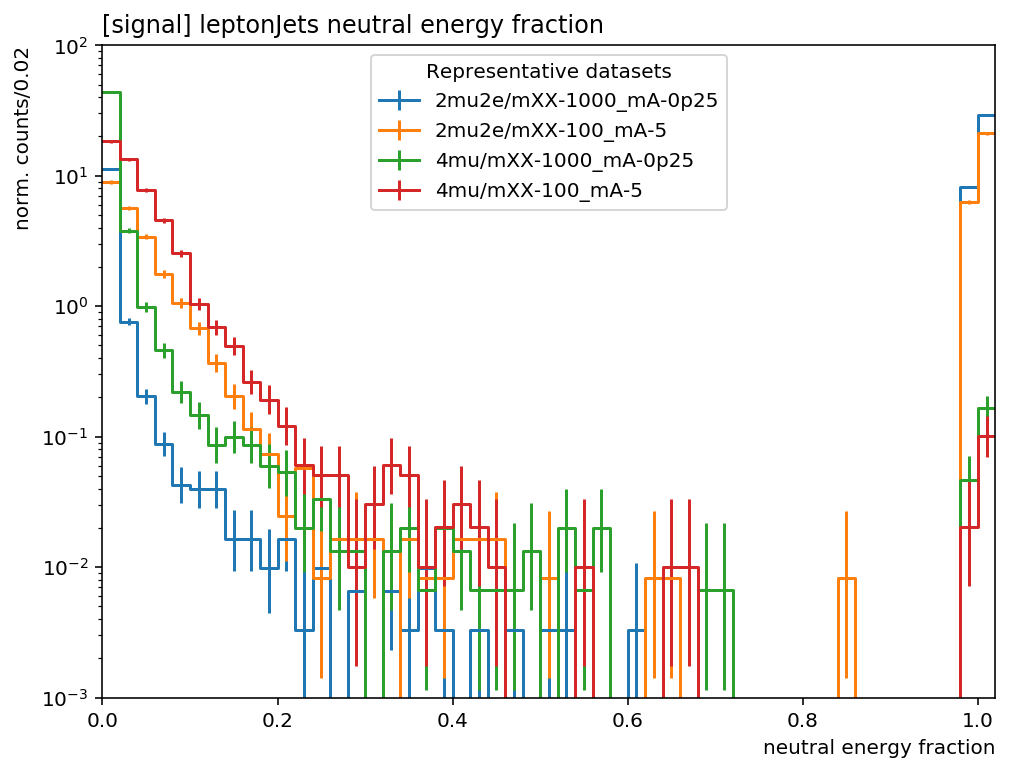

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['nef'], overlay='dataset', ax=ax, density=True, overflow='over')

ax.set_yscale('log')
ax.set_ylim([1e-3, 1e2])
ax.set_title('[signal] leptonJets neutral energy fraction', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

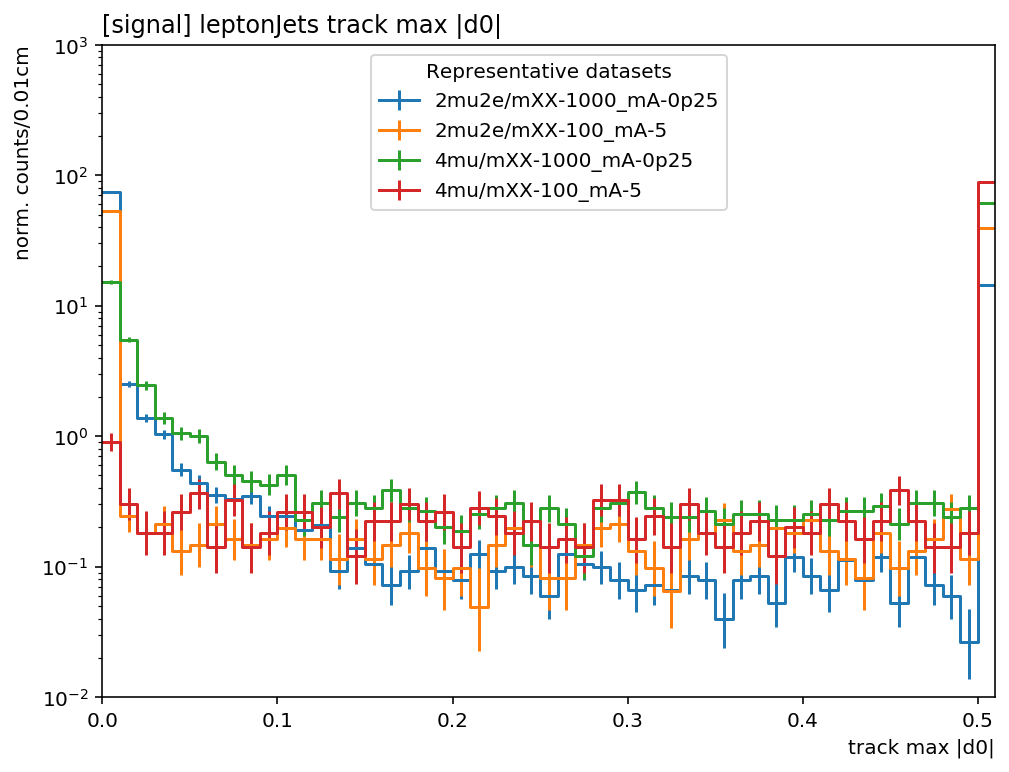

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['maxd0'], overlay='dataset', ax=ax, density=True, overflow='over')

ax.set_yscale('log')
ax.set_ylim([1e-2, 1e3])
ax.set_title('[signal] leptonJets track max |d0|', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

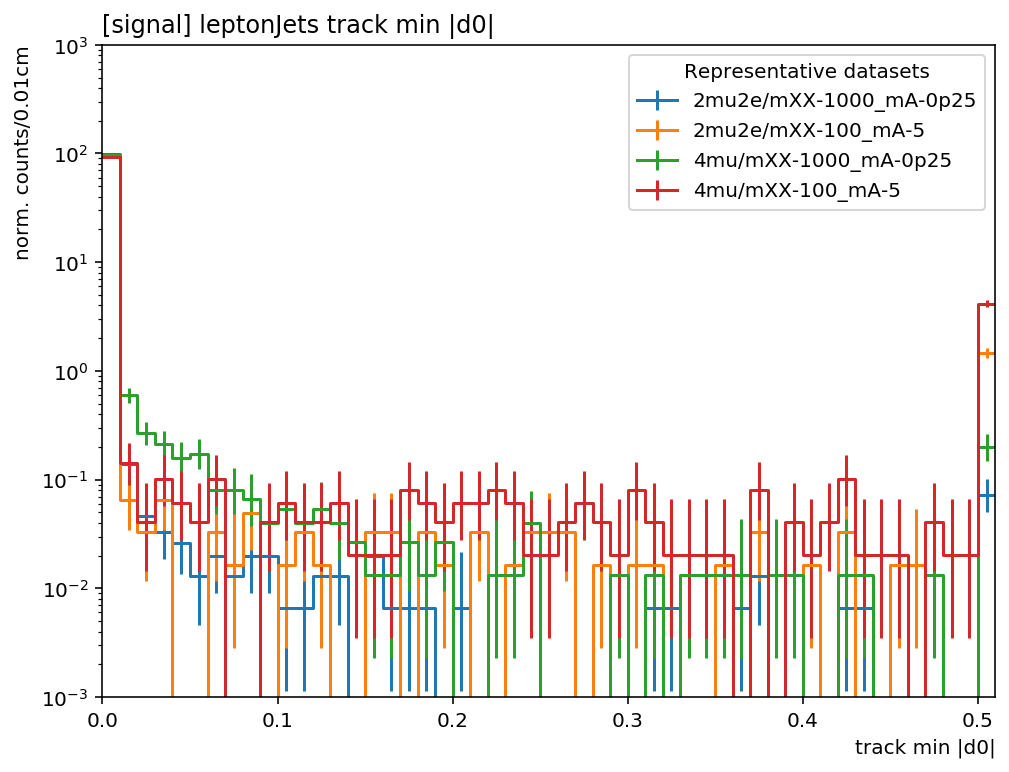

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['mind0'], overlay='dataset', ax=ax, density=True, overflow='over')

ax.set_yscale('log')
ax.set_ylim([1e-3, 1e3])
ax.set_title('[signal] leptonJets track min |d0|', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

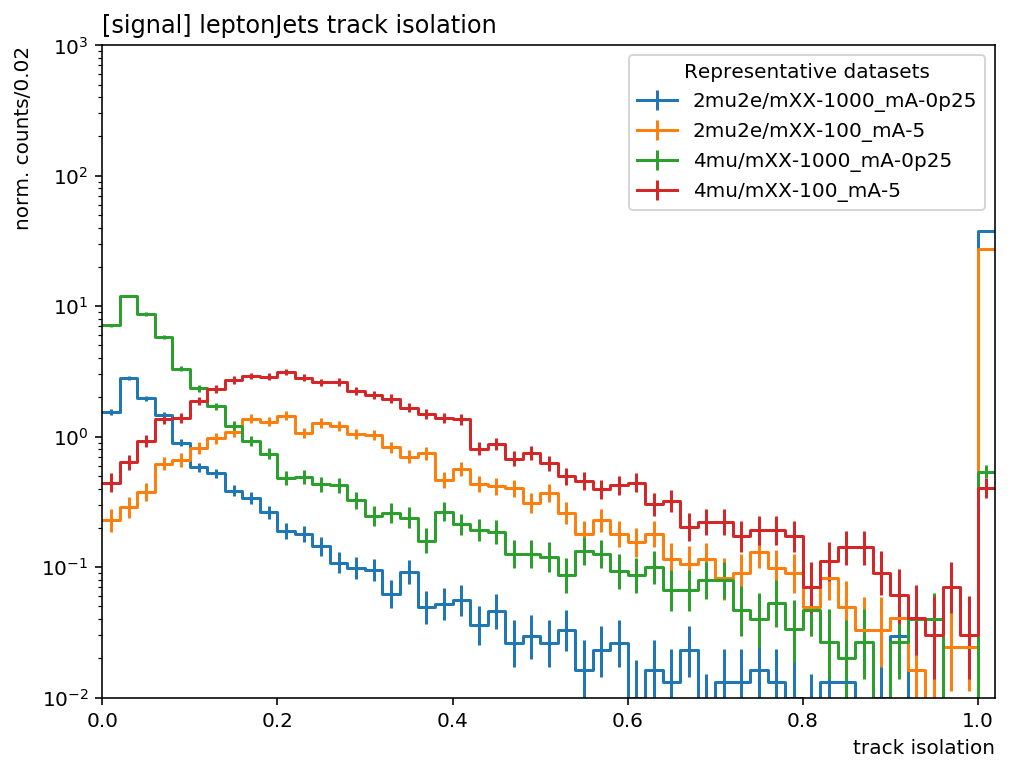

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['tkiso'], overlay='dataset', ax=ax, density=True, overflow='over')

ax.set_yscale('log')
ax.set_ylim([1e-2, 1e3])
ax.set_title('[signal] leptonJets track isolation', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

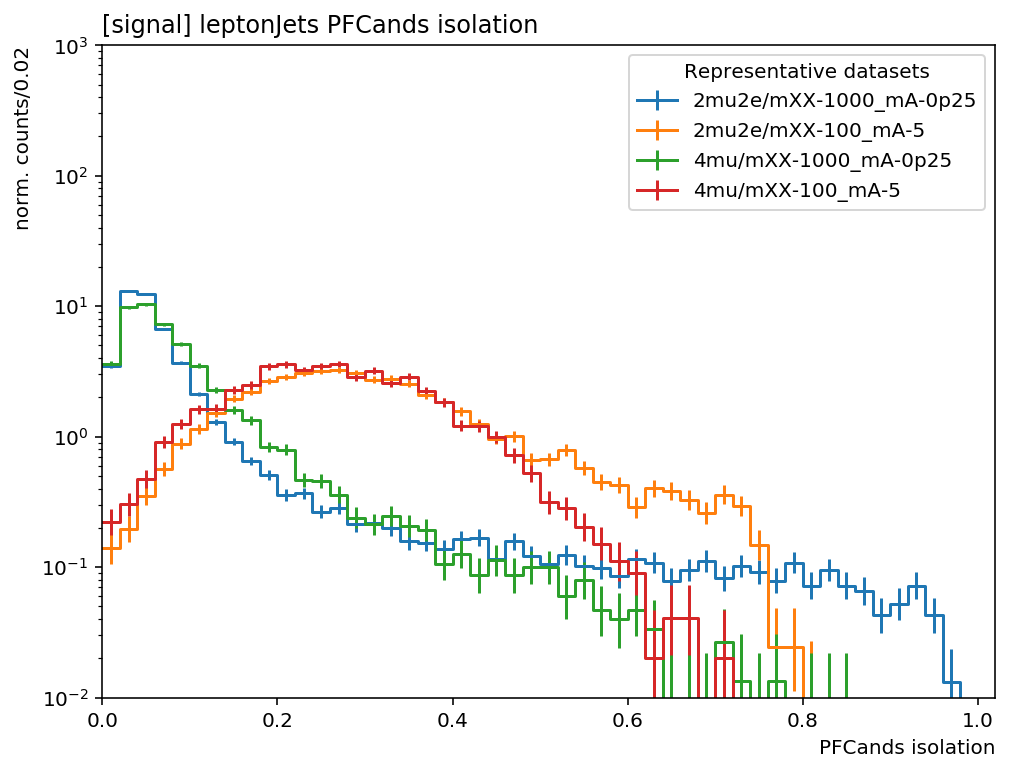

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['pfiso'], overlay='dataset', ax=ax, density=True, overflow='over')

ax.set_yscale('log')
ax.set_ylim([1e-2, 1e3])
ax.set_title('[signal] leptonJets PFCands isolation', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

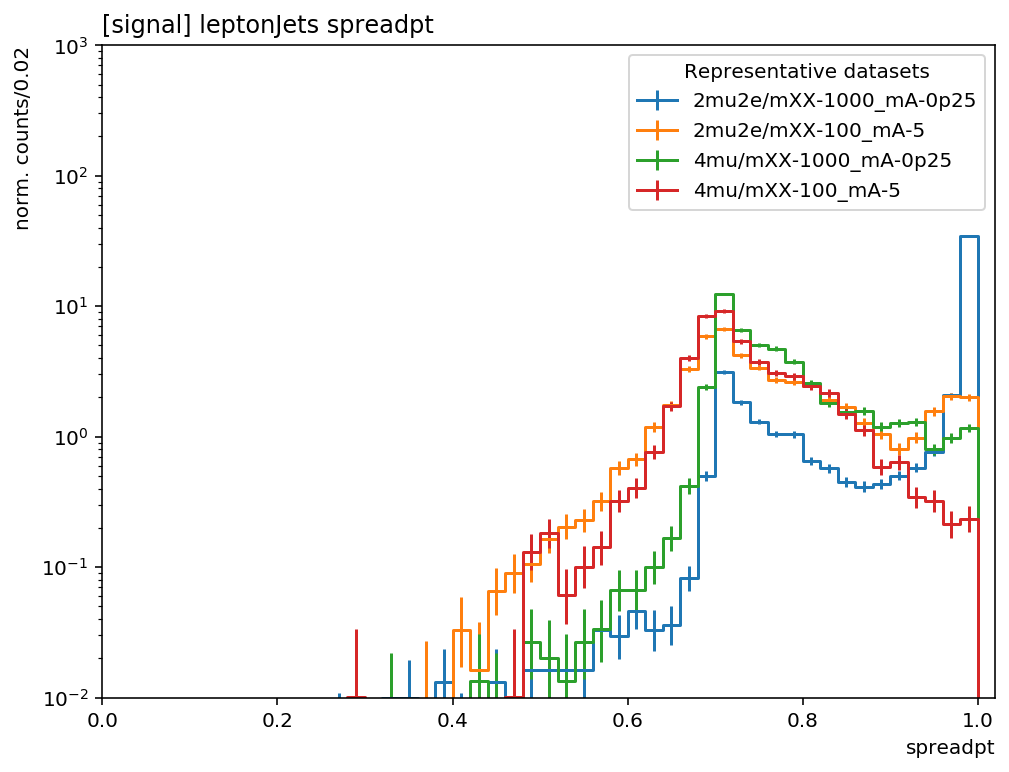

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['spreadpt'], overlay='dataset', ax=ax, density=True, overflow='over')

ax.set_yscale('log')
ax.set_ylim([1e-2, 1e3])
ax.set_title('[signal] leptonJets spreadpt', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

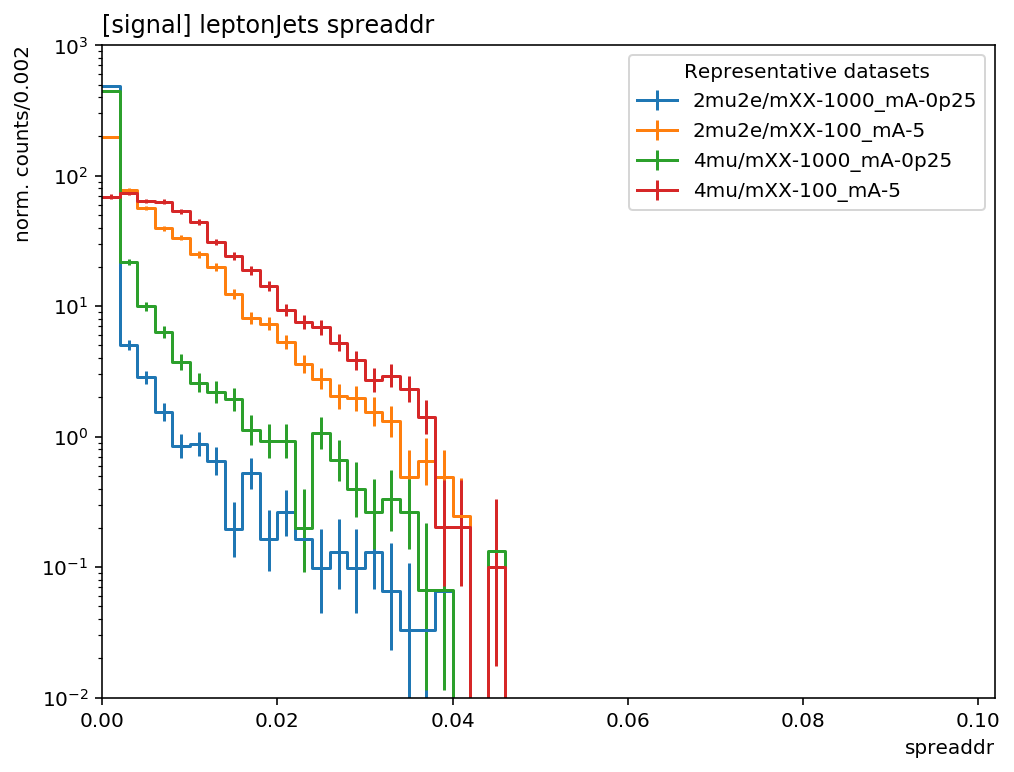

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['spreaddr'], overlay='dataset', ax=ax, density=True, overflow='over')

ax.set_yscale('log')
ax.set_ylim([1e-2, 1e3])
ax.set_title('[signal] leptonJets spreaddr', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

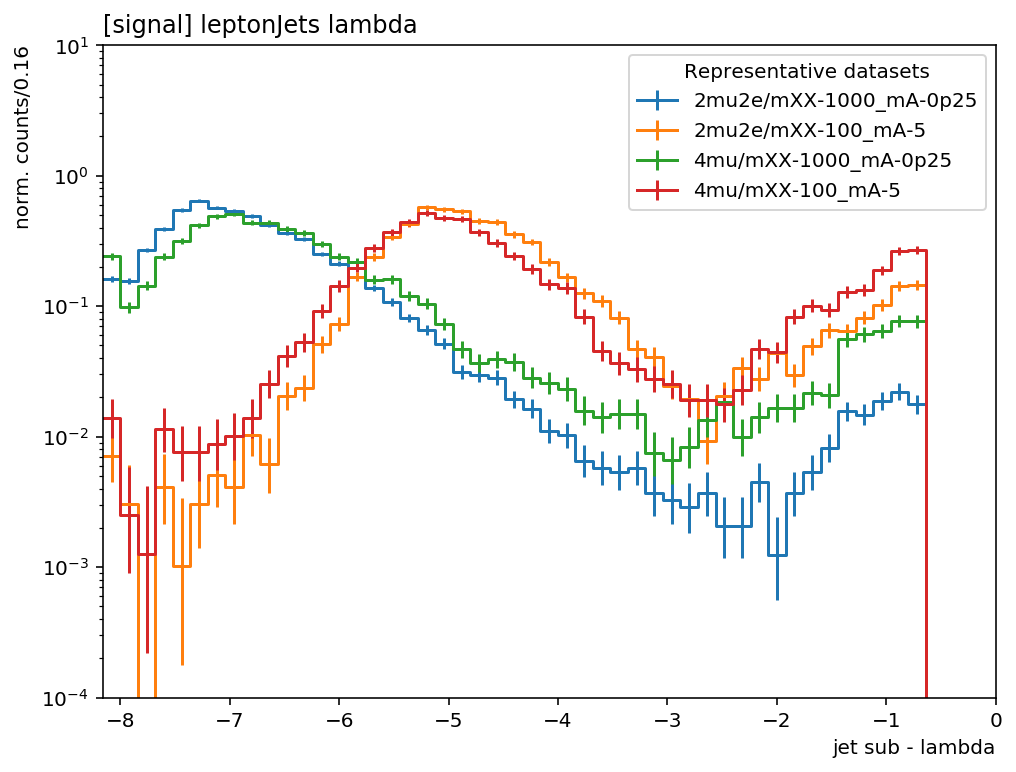

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['lamb'], overlay='dataset', ax=ax, density=True, overflow='under')

ax.set_yscale('log')
ax.set_ylim([1e-4, 1e1])
ax.set_title('[signal] leptonJets lambda', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

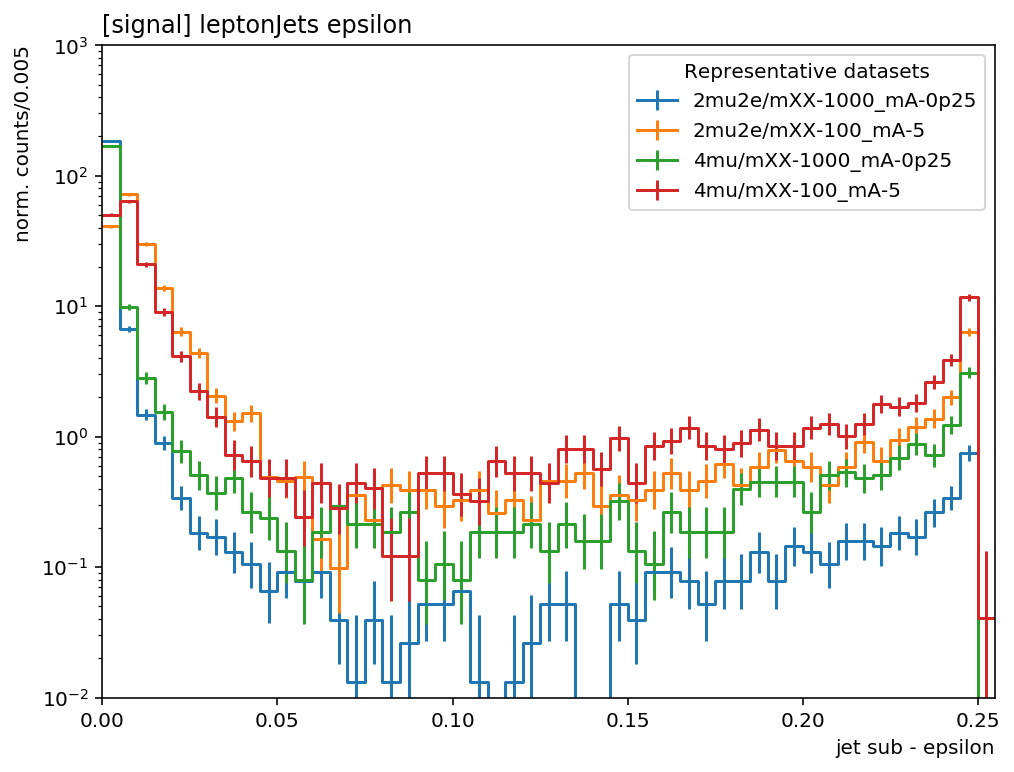

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['epsi'], overlay='dataset', ax=ax, density=True, overflow='over')

ax.set_yscale('log')
ax.set_ylim([1e-2, 1e3])
ax.set_title('[signal] leptonJets epsilon', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

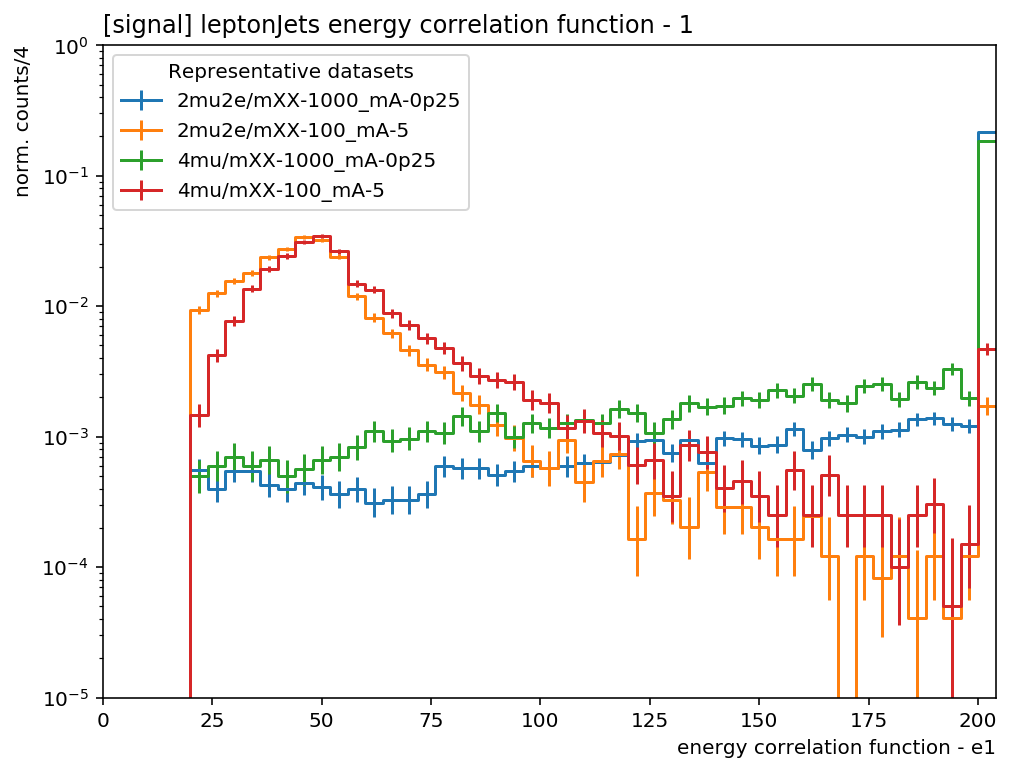

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['ecfe1'], overlay='dataset', ax=ax, density=True, overflow='over')

ax.set_yscale('log')
ax.set_ylim([1e-5, 1e0])
ax.set_title('[signal] leptonJets energy correlation function - 1', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

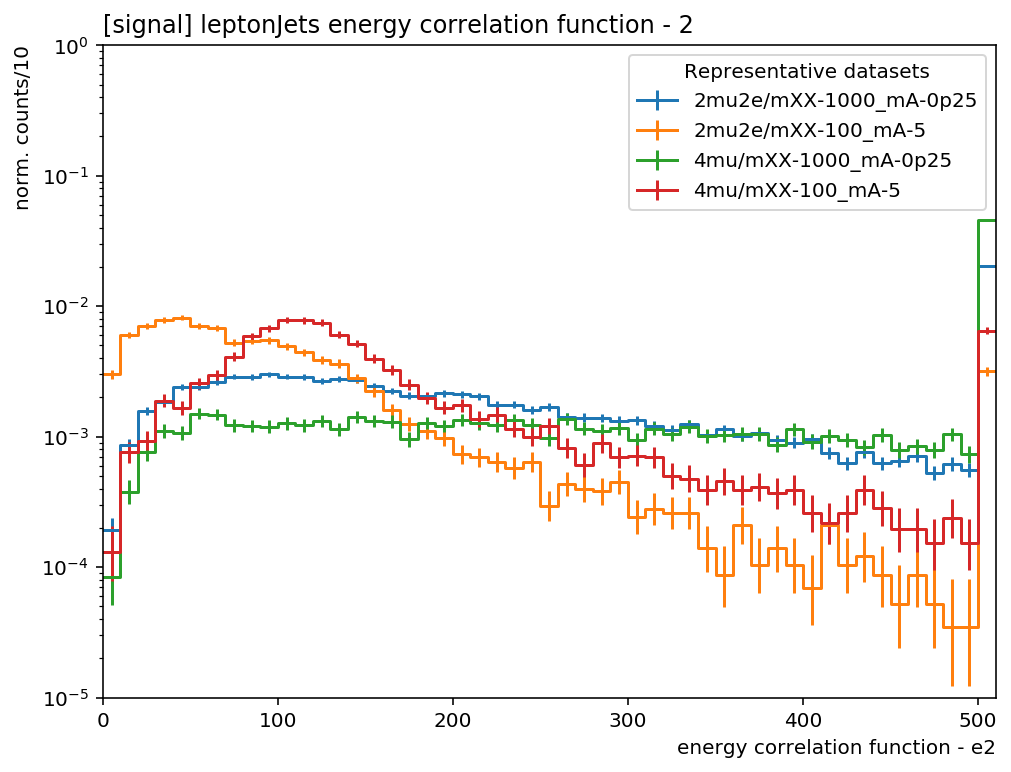

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['ecfe2'], overlay='dataset', ax=ax, density=True, overflow='over')

ax.set_yscale('log')
ax.set_ylim([1e-5, 1e0])
ax.set_title('[signal] leptonJets energy correlation function - 2', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

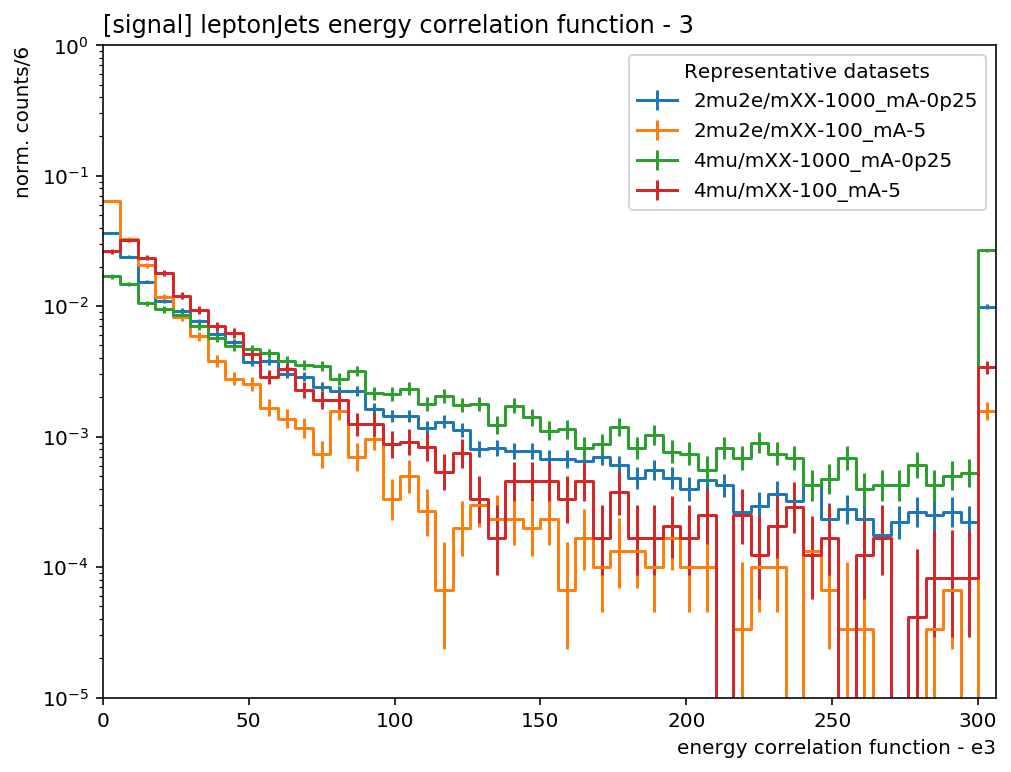

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['ecfe3'], overlay='dataset', ax=ax, density=True, overflow='over')

ax.set_yscale('log')
ax.set_ylim([1e-5, 1e0])
ax.set_title('[signal] leptonJets energy correlation function - 3', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

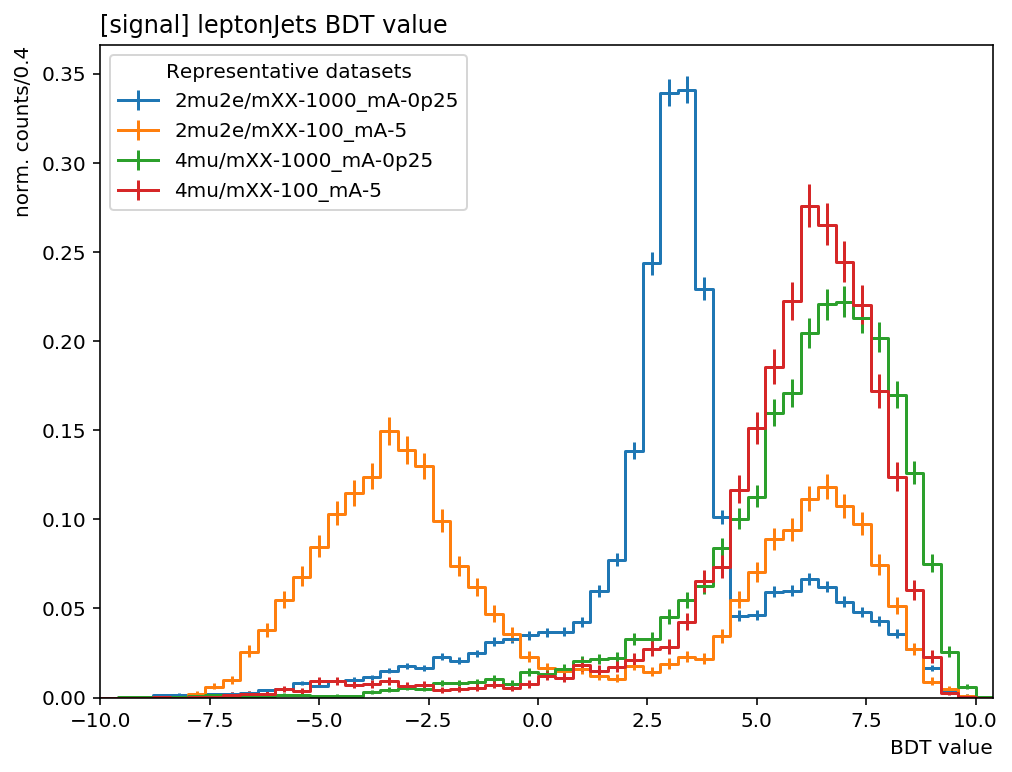

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['mva'], overlay='dataset', ax=ax, density=True, overflow='over')

# ax.set_yscale('log')
# ax.set_ylim([1e-5, 1e0])
ax.set_title('[signal] leptonJets BDT value', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

### leptonJet pair

In [7]:
class LeptonJetPairProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'signal')
        mass0_axis    = hist.Bin('mass', "mass [GeV]", 50, 50, 150) # small range
        mass1_axis    = hist.Bin('mass', "mass [GeV]", 50, 800, 1200) # large range
        dphi_axis = hist.Bin('dphi', "$\Delta\Phi$", 50, 0, 3.142)
        
        self._accumulator = processor.dict_accumulator({
            'mass0': hist.Hist("norm. counts/2GeV", dataset_axis, mass0_axis),
            'mass1': hist.Hist("norm. counts/8GeV", dataset_axis, mass1_axis),
            'dphi': hist.Hist("norm. counts/$\pi$/50", dataset_axis, dphi_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid']
        )
        darkphotons = genparticles[genparticles.pid==32]
        matchmask = leptonjets.match(darkphotons, deltaRCut=0.3)
        metfiltermask = np.logical_or.reduce([df[mf] for mf in MetFilters])
        leptonjets = leptonjets[matchmask][metfiltermask]
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size!=0:
            leadingLjPair = leptonjetpair[sumpt.argmax()]
            dphi = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))
            
            output['mass0'].fill(dataset=dataset, mass=leadingLjPair.mass.flatten())
            output['mass1'].fill(dataset=dataset, mass=leadingLjPair.mass.flatten())
            output['dphi'].fill(dataset=dataset, dphi=dphi.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [8]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetPairProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing:   0%|          | 0/20 [00:00<?, ?items/s]/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/

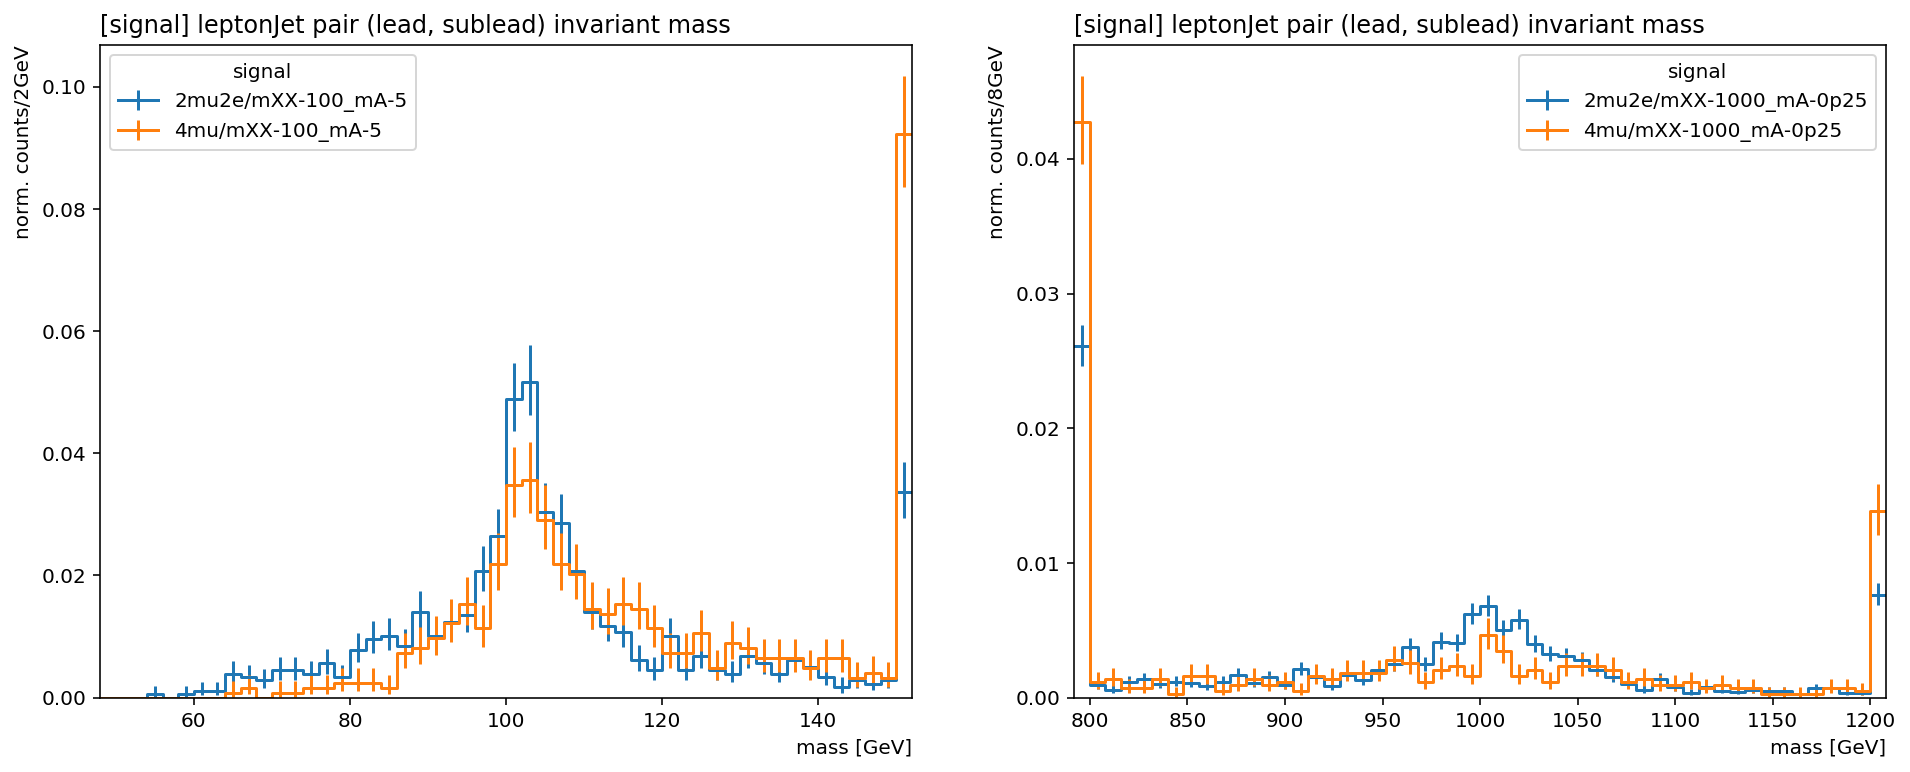

In [9]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig,ax,_ = hist.plot1d(output['mass0']['*/mXX-100_mA-5'], overlay='dataset', ax=axes[0], density=True, overflow='all')
fig,ax,_ = hist.plot1d(output['mass1']['*/mXX-1000_mA-0p25'], overlay='dataset', ax=axes[1], density=True, overflow='all')

for ax in axes:
#     ax.set_yscale('log')
    ax.set_title('[signal] leptonJet pair (lead, sublead) invariant mass', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

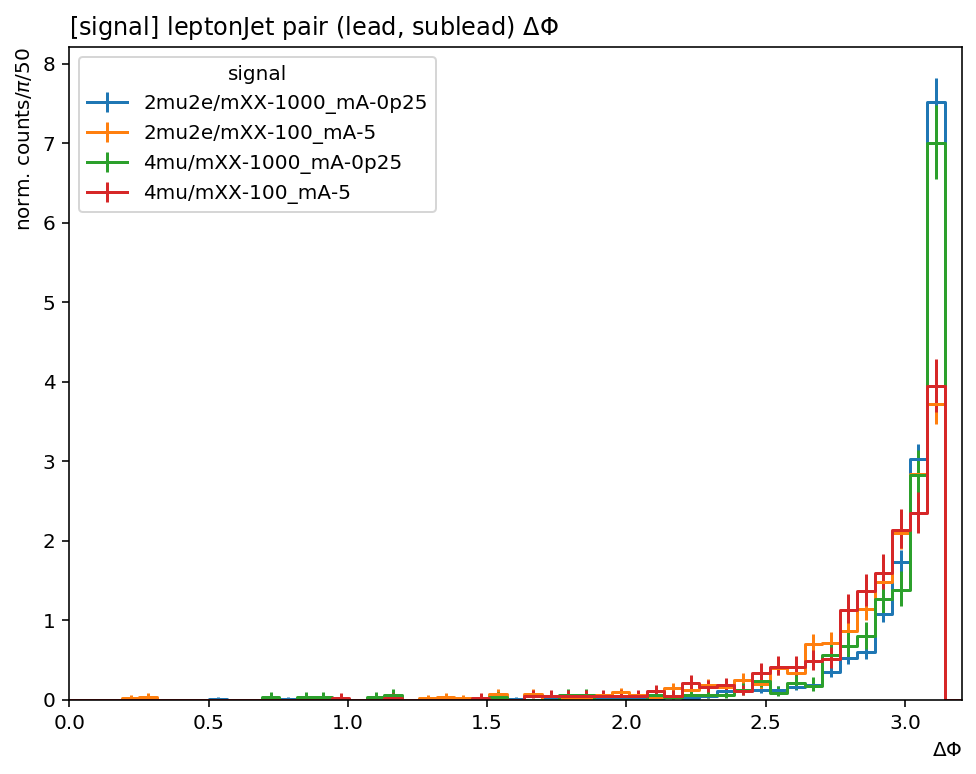

In [24]:
fig, ax = plt.subplots(figsize=(8,6))
fig,ax,_ = hist.plot1d(output['dphi'], overlay='dataset', ax=ax, density=True, overflow='over')

# ax.set_yscale('log')
# ax.set_ylim([1e-5, 1e0])
ax.set_title('[signal] leptonJet pair (lead, sublead) $\Delta\Phi$', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

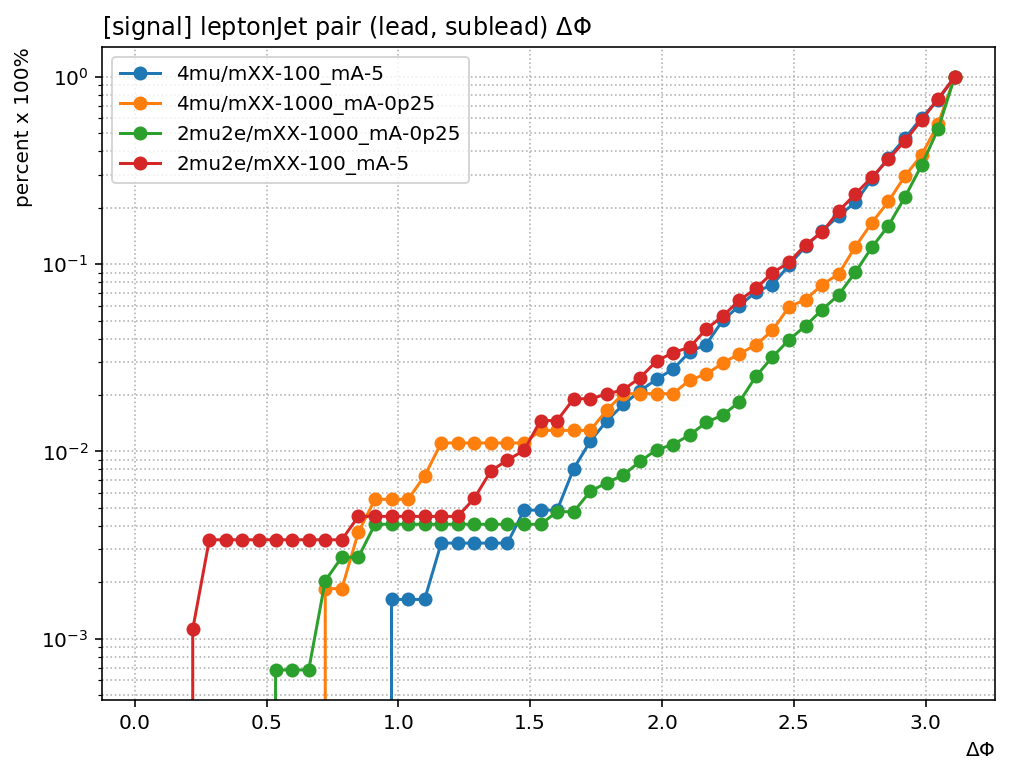

In [25]:
fig, ax = plt.subplots(figsize=(8,6))
for d in output['dphi'].values():
    label_ = d[0]
    val = output['dphi'].values()[d]
    val_ = np.cumsum(val)/np.sum(val)
    plt.plot(output['dphi'].axis('dphi').centers(), val_, marker='o', label=label_)
plt.legend()
ax.set_yscale('log')
ax.grid(which='both', ls=':')
ax.set_title('[signal] leptonJet pair (lead, sublead) $\Delta\Phi$', x=0.0, ha="left")
ax.set_xlabel('$\Delta\Phi$', x=1.0, ha="right")
ax.set_ylabel('percent x 100%', y=1.0, ha="right");